## ExportDataOnly

2025-09-01 04:31:47,560 [INFO] ⏳ Initializing Earth Engine
2025-09-01 04:31:48,671 [INFO] ✅ Initializing Earth Engine — 1.11s
2025-09-01 04:31:48,672 [INFO] ⏳ Locating and extracting shapefile
2025-09-01 04:31:48,885 [INFO] ✅ Using shapefile: /tmp/alpha_earth_part3_extract_rtmfsnnu/alpha_earth_part3.shp — 0.21s
2025-09-01 04:31:48,885 [INFO] ⏳ Reading + cleaning shapefile
2025-09-01 04:31:49,272 [INFO] Filter COD_TV: kept 500/500 polygons matching 5 allowed value(s).
2025-09-01 04:31:49,512 [INFO] 🔎 Polygon filter ≥ 10000 m²: kept 500/500 features.
2025-09-01 04:31:49,577 [INFO] Saved label map with 5 classes → /app/alpha_earth_part3_label_map.json
2025-09-01 04:31:49,579 [INFO] ✅ Shapefile cleaned & labels mapped — 0.69s
2025-09-01 04:31:49,579 [INFO] ⏳ Building minimal enclosing squares per polygon
2025-09-01 04:31:49,793 [INFO] 🟰 Class mix in selected 500 tiles: 1:100, 2:100, 3:100, 4:100, 5:100
2025-09-01 04:31:49,794 [INFO] 🟩 Prepared 500 square region(s) for export (balanced=True

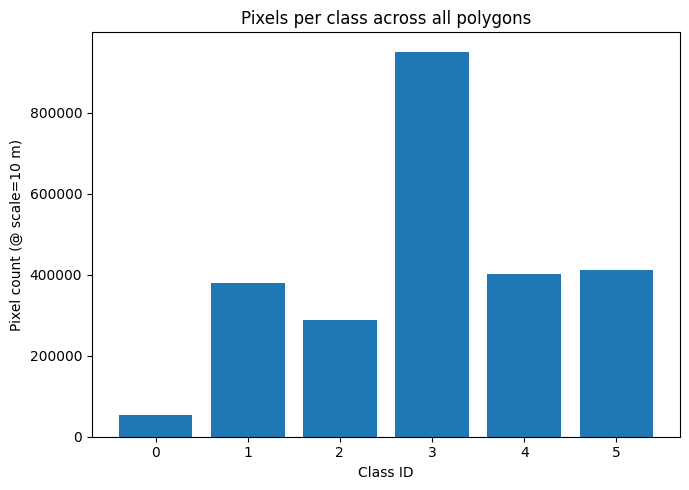

2025-09-01 04:32:09,111 [INFO] ✅ Class stats computed and plotted — 17.68s
2025-09-01 04:32:09,112 [INFO] ℹ️ RUN_EXPORTS=False → skipped starting exports. Use the stats above to decide.


In [ ]:
# pip install earthengine-api geopandas shapely fiona rasterio matplotlib

import os, sys, time, logging, subprocess, zipfile, tempfile, math, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import ee
import matplotlib.pyplot as plt

from shapely.geometry import box, mapping
from shapely.ops import unary_union

# =========================
# CONFIG — edit as needed
# =========================


BASENAME = "alpha_earth_part3"
LABEL_FIELD         = "COD_TV"                 # class column in shapefile (will be remapped to ints)
YEAR                = 2024
EXPORT_TO           = "Drive"                  # "Drive" or "GCS"
GCS_BUCKET          = None                     # set if EXPORT_TO == "GCS"
FILE_PREFIX         = f"alphaearth_embeddings_{YEAR}"

SRC_METRIC_EPSG     = 25830                    # meter CRS of your shapefile
SIMPLIFY_TOL_M      = 8.0
BUFFER_M            = 0.0

# Square generation
PAD_METERS          = 0.0 #Changing this param will not change analytics, only the exported images

#### In a future ----> Understand what model we want to train (chip size, number of bands, etc) and create a "minimum bound box" which will compose our .tiff. 
### Te action above will make things work since the beggining and data engineering efficient.


# Selection / limits
MAX_EXPORTS             = 500
EXPORT_SCALE            = 10                    # meters; MUST match your model assumptions
FILE_DIM_MAX            = 8192
MAX_FILESIZE_BYTES      = 17_000_000_000
BYTES_PER_SAMPLE        = 4
MAX_PIXELS_ALLOWED      = 1e13

# Area thresholds (in m²)
MIN_POLY_AREA_M2        = 10_000.0
MIN_SQUARE_AREA_M2      = 10_000.0

# Optional manual AOI (WGS84); set to None to skip
RECT_WGS = None


# Experiment 1 
# 
# RECT_WGS =  box(-6.354297183434425, 42.836918068732686,
#                -5.434101682953294, 43.070709916789845)

#   ALLOW_COD_TV = [
#     "61.a.02.004+55.a.02.101",
#     "52.a.05.006+52.b.08.101",
# ]

# Toggle to actually submit exports (keep False to only see stats/histogram)
RUN_EXPORTS = False

# === allow-list of COD_TV values to keep (exact match). Leave [] to keep all. ===
ALLOW_COD_TV = [
"61.a.04.010+55.a.02.101",
"52.b.08.101+27.a.03.101",
"59.b.04.101+59.b.06.101",
"52.b.09.101",
"52.a.05.006+52.b.08.101"
]




# === request-payload guardrails ===
MAX_REQUEST_PAYLOAD_BYTES = 10_000_000          # EE hard limit ~10 MB
PAYLOAD_SAFETY_MARGIN     = 0.90                # target ~9 MB
MAX_SIMPLIFY_TOL_M        = 2048.0              # upper bound for progressive simplification
BOUNDS_FALLBACK           = True                # final fallback to bounding box for stats if needed

# --- Tile balancing (post-filtering) ---
BALANCE_TILES        = True   # turn on/off balancing
BALANCE_SEED         = 2025
MIN_PER_CLASS        = 0      # optional floor per class

# =========================
# LOGGING
# =========================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
log = logging.getLogger("alphaearth")
def tic(msg): log.info(f"⏳ {msg}"); return time.time(), msg
def toc(t0, msg): log.info(f"✅ {msg} — {time.time()-t0:.2f}s")

# =========================
# EE INIT
# =========================
t0,_ = tic("Initializing Earth Engine")
try:
    ee.Number(1).getInfo()
except Exception:
    ee.Initialize()
toc(t0, "Initializing Earth Engine")

# =========================
# HELPERS
# =========================
def git_root_or_cwd() -> Path:
    try:
        root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
        return Path(root)
    except Exception:
        return Path.cwd()

def meters_to_deg(m: float) -> float:
    return float(m) / 111_320.0

def shapely_to_ee_geometry(geom_wgs84):
    gj = mapping(geom_wgs84)
    if gj["type"] == "Polygon":
        return ee.Geometry.Polygon(gj["coordinates"], proj='EPSG:4326', geodesic=False)
    elif gj["type"] == "MultiPolygon":
        return ee.Geometry.MultiPolygon(gj["coordinates"], proj='EPSG:4326', geodesic=False)
    else:
        raise ValueError(f"Unsupported geometry type: {gj['type']}")

def square_cover_metric(geom_metric, pad_m=0.0):
    minx, miny, maxx, maxy = geom_metric.bounds
    side = max(maxx - minx, maxy - miny) + 2*pad_m
    cx = 0.5*(minx + maxx); cy = 0.5*(miny + maxy); half = 0.5*side
    return box(cx - half, cy - half, cx + half, cy + half)

def metric_to_wgs(poly_metric, epsg_metric=SRC_METRIC_EPSG):
    return gpd.GeoSeries([poly_metric], crs=epsg_metric).to_crs(4326).iloc[0]

def estimate_uncompressed_bytes(area_m2, scale_m, n_bands, bytes_per_sample):
    px = max(1.0, area_m2 / float(scale_m*scale_m))
    return px * n_bands * bytes_per_sample

def safe_file_dim(n_bands, bytes_per_sample,
                  hard_cap=MAX_FILESIZE_BYTES, align=256, max_dim=FILE_DIM_MAX):
    BYTES_PER_PIXEL = n_bands * bytes_per_sample
    HARD_LIMIT = min(hard_cap, 17_000_000_000)
    raw = int(((HARD_LIMIT / BYTES_PER_PIXEL) ** 0.5))
    dim = min(max_dim, raw)
    dim = max(align, (dim // align) * align)
    return dim

# --- payload sizing + simplification helpers ---
def approx_geojson_bytes(gdf_wgs84: gpd.GeoDataFrame) -> int:
    return len(gdf_wgs84.to_json())

def simplify_for_payload(gdf_wgs84: gpd.GeoDataFrame,
                         base_tol_m: float,
                         max_bytes: int = int(MAX_REQUEST_PAYLOAD_BYTES * PAYLOAD_SAFETY_MARGIN),
                         max_tol_m: float = MAX_SIMPLIFY_TOL_M):
    size0 = approx_geojson_bytes(gdf_wgs84)
    if size0 <= max_bytes:
        return gdf_wgs84, 0.0, size0, "original"

    log.warning(f"Payload precheck: ~{size0/1e6:.2f} MB > {max_bytes/1e6:.2f} MB. Simplifying...")
    gdf_m = gdf_wgs84.to_crs(SRC_METRIC_EPSG).copy()

    tol = max(1.0, base_tol_m)
    while tol <= max_tol_m:
        gdf_s = gdf_m.copy()
        gdf_s["geometry"] = gdf_s.geometry.simplify(tol, preserve_topology=True).buffer(0)
        gdf_s = gdf_s[gdf_s.geometry.is_valid & ~gdf_s.geometry.is_empty]
        gdf_s_wgs = gdf_s.to_crs(4326)
        size = approx_geojson_bytes(gdf_s_wgs)
        log.info(f"  - try tol={tol:.1f} m → ~{size/1e6:.2f} MB")
        if size <= max_bytes:
            return gdf_s_wgs, tol, size, "simplified"
        tol *= 2.0

    # Final fallback: per-feature envelopes (rectangles)
    gdf_env_m = gdf_m.copy()
    gdf_env_m["geometry"] = gdf_env_m.geometry.envelope.buffer(0)
    gdf_env_m = gdf_env_m[gdf_env_m.geometry.is_valid & ~gdf_env_m.geometry.is_empty]
    gdf_env_wgs = gdf_env_m.to_crs(4326)
    size_env = approx_geojson_bytes(gdf_env_wgs)
    log.warning(f"  - using envelopes fallback → ~{size_env/1e6:.2f} MB")
    return gdf_env_wgs, -1.0, size_env, "envelopes"

# --- tile balancing helper ---
def stratified_pick(df: pd.DataFrame, label_col: str, N: int,
                    seed: int = 42, min_per_class: int = 0) -> pd.DataFrame:
    """
    Try to return ~balanced sample of N rows across classes in label_col.
    - First pass: take floor(N / K) (>= min_per_class) from each class, or as many as available.
    - Second pass: fill remaining from classes that still have unused rows.
    """
    groups = {c: g.copy() for c, g in df.groupby(label_col)}
    classes = list(groups.keys())
    K = max(1, len(classes))
    base_target = max(min_per_class, N // K)
    picks = []

    # pass 1: take up to base_target per class (random)
    for c in classes:
        g = groups[c]
        k = min(base_target, len(g))
        if k > 0:
            picks.append(g.sample(n=k, random_state=seed))
            groups[c] = g.drop(picks[-1].index)

    chosen = pd.concat(picks) if picks else df.iloc[0:0]
    remaining = N - len(chosen)
    if remaining <= 0:
        return chosen.head(N)

    # pass 2: fill remaining from pooled leftovers (random)
    leftovers = [g for g in groups.values() if not g.empty]
    pool = pd.concat(leftovers) if leftovers else df.iloc[0:0]
    if not pool.empty:
        k = min(remaining, len(pool))
        extra = pool.sample(n=k, random_state=seed)
        chosen = pd.concat([chosen, extra], axis=0).drop_duplicates()

    return chosen.head(min(N, len(chosen)))

# =========================
# LOCATE & EXTRACT SHAPEFILE
# =========================
t0,_ = tic("Locating and extracting shapefile")
repo_root = git_root_or_cwd()
zip_matches = list(repo_root.rglob(f"{BASENAME}.zip"))
if not zip_matches:
    raise FileNotFoundError(f"Could not find {BASENAME}.zip under {repo_root}")
zip_path = zip_matches[0]

extract_dir = Path(tempfile.mkdtemp(prefix=f"{BASENAME}_extract_"))
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)
shp_candidates = list(extract_dir.rglob("*.shp"))
if not shp_candidates:
    raise FileNotFoundError(f"No .shp found inside zip: {zip_path}")
shp_path = shp_candidates[0]
toc(t0, f"Using shapefile: {shp_path}")

# =========================
# READ + CLEAN SHAPEFILE WITH LABELS
# =========================
t0,_ = tic("Reading + cleaning shapefile")
gdf = gpd.read_file(shp_path)
if gdf.crs is None:
    raise ValueError("Input shapefile lacks a CRS.")
if LABEL_FIELD not in gdf.columns:
    raise ValueError(f"Label field {LABEL_FIELD} not found in shapefile.")

# Optional AOI clip
gdf_clip = gdf.to_crs(4326)
if RECT_WGS is not None:
    gdf_clip = gdf_clip[gdf_clip.geometry.intersects(RECT_WGS)]
    if len(gdf_clip) == 0:
        log.warning("AOI clipping produced 0 features; falling back to full shapefile.")
        gdf_clip = gdf.to_crs(4326)

# Filter polygons by COD_TV allow-list (exact match) BEFORE mapping to ints
if ALLOW_COD_TV:
    allow = set(str(v) for v in ALLOW_COD_TV)
    before_cnt = len(gdf_clip)
    gdf_clip = gdf_clip[gdf_clip[LABEL_FIELD].astype(str).isin(allow)].copy()
    after_cnt = len(gdf_clip)
    if after_cnt == 0:
        raise ValueError(
            f"After filtering by ALLOW_COD_TV, no polygons remain. "
            f"Provided values={sorted(list(allow))}"
        )
    log.info(f"Filter COD_TV: kept {after_cnt}/{before_cnt} polygons matching {len(allow)} allowed value(s).")

# Repair + area filter in metric CRS
gdf_clip_m = gdf_clip.to_crs(SRC_METRIC_EPSG).copy()
gdf_clip_m["geometry"] = gdf_clip_m.buffer(0)  # repair invalids
gdf_clip_m = gdf_clip_m[gdf_clip_m.geometry.is_valid & ~gdf_clip_m.geometry.is_empty]
gdf_clip_m["__area_m2"] = gdf_clip_m.geometry.area.astype(float)

before = len(gdf_clip_m)
gdf_clip_m = gdf_clip_m[gdf_clip_m["__area_m2"] >= MIN_POLY_AREA_M2]
after = len(gdf_clip_m)
if after == 0:
    raise ValueError(f"All features were < {MIN_POLY_AREA_M2:.0f} m² after cleaning. Nothing to export.")
log.info(f"🔎 Polygon filter ≥ {MIN_POLY_AREA_M2:.0f} m²: kept {after}/{before} features.")

# Back to WGS84, drop temp area col
gdf_clip = gdf_clip_m.drop(columns=["__area_m2"], errors="ignore").to_crs(4326)

# === LABEL MAPPING (string → int IDs 1..N) & persist to JSON ===
unique_labels = sorted([str(v) for v in gdf_clip[LABEL_FIELD].unique()])
label_map = {lab: i+1 for i, lab in enumerate(unique_labels)}  # 1..N (0 reserved for background)
map_path = repo_root / f"{BASENAME}_label_map.json"
json.dump(label_map, open(map_path, "w"))
log.info(f"Saved label map with {len(label_map)} classes → {map_path}")

# Re-encode labels to ints in working GDF
gdf_clip[LABEL_FIELD] = gdf_clip[LABEL_FIELD].astype(str).map(label_map).fillna(0).astype(int)
toc(t0, "Shapefile cleaned & labels mapped")

# =========================
# BUILD SQUARES PER POLYGON
# =========================
t0,_ = tic("Building minimal enclosing squares per polygon")
squares_rows = []
gdf_m = gdf_clip.to_crs(SRC_METRIC_EPSG).copy()

for idx, row in gdf_m.iterrows():
    geom = row.geometry
    if geom is None or geom.is_empty:
        continue
    sq_m = square_cover_metric(geom, pad_m=PAD_METERS)
    area_m2 = float(sq_m.area)
    if area_m2 < MIN_SQUARE_AREA_M2:
        continue

    sq_wgs   = metric_to_wgs(sq_m, SRC_METRIC_EPSG)
    poly_wgs = gdf_clip.loc[idx, "geometry"]   # original polygon (WGS84)
    lab      = int(gdf_clip.loc[idx, LABEL_FIELD])  # already mapped to int

    squares_rows.append({
        "geometry": sq_wgs,
        "poly_wgs": poly_wgs,
        "area_m2": area_m2,
        LABEL_FIELD: lab
    })

squares_gdf = gpd.GeoDataFrame(squares_rows, geometry="geometry", crs=4326)
if squares_gdf.empty:
    raise RuntimeError("No squares produced from shapefile; check MIN_SQUARE_AREA_M2 or source geometry.")

# Dedup same square+label
squares_gdf["wkt"] = squares_gdf.geometry.apply(lambda g: g.wkt)
squares_gdf = (squares_gdf
               .sort_values("area_m2", ascending=False)
               .drop_duplicates(subset=["wkt", LABEL_FIELD])
               .drop(columns=["wkt"])
               .reset_index(drop=True))

# Sort by area (for quality) then BALANCE to MAX_EXPORTS
squares_gdf = squares_gdf.sort_values("area_m2", ascending=False).reset_index(drop=True)

if BALANCE_TILES and len(squares_gdf) > MAX_EXPORTS:
    balanced = stratified_pick(
        squares_gdf,
        label_col=LABEL_FIELD,
        N=MAX_EXPORTS,
        seed=BALANCE_SEED,
        min_per_class=MIN_PER_CLASS
    )
    squares_gdf = (balanced
                   .sort_values("area_m2", ascending=False)
                   .reset_index(drop=True))
else:
    squares_gdf = squares_gdf.head(MAX_EXPORTS)

# (Optional) show class mix after selection
mix = squares_gdf[LABEL_FIELD].value_counts().sort_index()
log.info(f"🟰 Class mix in selected {len(squares_gdf)} tiles: " +
         ", ".join([f"{cls}:{cnt}" for cls, cnt in mix.items()]))
log.info(f"🟩 Prepared {len(squares_gdf)} square region(s) for export (balanced={BALANCE_TILES}).")
toc(t0, "Squares built & balanced")

# =========================
# EMBEDDINGS IMAGE & SAFE fileDimensions
# =========================
t0,_ = tic("Building embeddings and computing safe fileDimensions")
emb = (ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
       .filterDate(ee.Date.fromYMD(YEAR,1,1), ee.Date.fromYMD(YEAR+1,1,1))
       .mosaic())
emb32 = emb.toFloat().unmask(0)

try:
    emb_band_count = len(emb.bandNames().getInfo())  # expect 64
except Exception:
    emb_band_count = 64

N_BANDS_EXPORT = emb_band_count + 1  # embeddings + label
SAFE_DIM = safe_file_dim(
    n_bands=N_BANDS_EXPORT,
    bytes_per_sample=BYTES_PER_SAMPLE,
    hard_cap=MAX_FILESIZE_BYTES,
    align=256,
    max_dim=FILE_DIM_MAX
)
log.info(f"📏 Using fileDimensions={SAFE_DIM} (pixels) for all square exports.")
toc(t0, "Embeddings ready & file dim computed")

# =========================
# Payload-safe copy for EE FeatureCollection/statistics
# =========================
t0,_ = tic("Payload precheck & simplification for EE upload")
gdf_for_fc, used_tol_m, est_bytes, strategy = simplify_for_payload(
    gdf_wgs84=gdf_clip,  # NOTE: this already contains LABEL_FIELD mapped to int
    base_tol_m=SIMPLIFY_TOL_M
)
if strategy == "original":
    log.info(f"Payload OK without simplify (~{est_bytes/1e6:.2f} MB).")
elif strategy == "simplified":
    log.warning(f"Using simplified polygons (tol≈{used_tol_m:.1f} m, ~{est_bytes/1e6:.2f} MB).")
else:
    log.warning(f"Using envelopes (rectangles) for stats (~{est_bytes/1e6:.2f} MB).")
toc(t0, "Geometries prepared")

# =========================
# BUILD EE FEATURECOLLECTION (for stats + rasterization)
# =========================
t0,_ = tic("Building EE FeatureCollection")
ee_feats = []
for _, r in gdf_for_fc.iterrows():
    ee_geom = shapely_to_ee_geometry(r.geometry)
    label_val = int(r[LABEL_FIELD])  # already integer-mapped
    ee_feats.append(ee.Feature(ee_geom, {"label": label_val}))
fc = ee.FeatureCollection(ee_feats)
full_region = fc.geometry()
toc(t0, "EE FeatureCollection ready")

# =========================
# RASTERIZE LABELS (0 outside polygons) FOR STATS
# =========================
label_img = (ee.Image(0)
             .paint(fc, "label")
             .rename("label")
             .toInt())

# =========================
# PRE-EXPORT CLASS STATS (PIXELS & AREA) with resilient payload handling
# =========================
t0,_ = tic("Computing class stats (pixels & area)")
def compute_stats(region_geom):
    freq = label_img.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=region_geom,
        scale=EXPORT_SCALE,
        maxPixels=int(MAX_PIXELS_ALLOWED),
        tileScale=4
    )
    freq_dict = ee.Dictionary(freq.get("label"))
    area_grouped = (ee.Image.pixelArea()
                    .addBands(label_img)
                    .reduceRegion(
                        reducer=ee.Reducer.sum().group(groupField=1, groupName="label"),
                        geometry=region_geom,
                        scale=EXPORT_SCALE,
                        maxPixels=int(MAX_PIXELS_ALLOWED),
                        tileScale=4
                    ))
    return freq_dict, area_grouped

try:
    freq_dict, area_grouped = compute_stats(full_region)
except Exception as e:
    msg = str(e)
    if "payload size exceeds the limit" in msg.lower() and BOUNDS_FALLBACK:
        log.warning("⚠️ Payload still too large for stats. Falling back to bounding box of simplified region.")
        bbox = full_region.bounds(1)  # 1 m error ok
        freq_dict, area_grouped = compute_stats(bbox)
    else:
        raise

freq_local = ee.Dictionary(freq_dict).getInfo()
area_groups = ee.Dictionary(area_grouped).get("groups").getInfo()

px_per_class = {int(k): int(v) for k, v in freq_local.items()}
m2_per_class = {int(g["label"]): float(g["sum"]) for g in area_groups}

summary_rows = []
for lab, px in sorted(px_per_class.items()):
    m2 = m2_per_class.get(lab, px * (EXPORT_SCALE**2))
    summary_rows.append({
        "class_id": lab,
        "pixels": px,
        "area_m2": m2,
        "area_ha": m2 / 10_000.0,
        "area_km2": m2 / 1_000_000.0
    })

df_summary = pd.DataFrame(summary_rows).sort_values("class_id").reset_index(drop=True)
log.info("\n" + df_summary.to_string(index=False))

plt.figure(figsize=(7,5))
plt.bar(df_summary["class_id"].astype(str), df_summary["pixels"])
plt.xlabel("Class ID")
plt.ylabel(f"Pixel count (@ scale={EXPORT_SCALE} m)")
plt.title("Pixels per class across all polygons")
plt.tight_layout()
plt.show()

toc(t0, "Class stats computed and plotted")

# =========================
# EXPORTER
# =========================
def const_label_image(label_int: int) -> ee.Image:
    return ee.Image.constant(label_int).rename("label").toFloat()

def export_square(row, i, folder_or_bucket=None):
    region    = row.geometry
    label_val = int(row[LABEL_FIELD])
    poly_wgs  = row["poly_wgs"]

    ee_geom = ee.Geometry.Rectangle(list(region.bounds), proj='EPSG:4326', geodesic=False)
    ee_poly = shapely_to_ee_geometry(poly_wgs)

    label_band = (ee.Image.constant(label_val)
                  .rename("label")
                  .clip(ee_poly)
                  .unmask(0)
                  .toFloat())

    img = ee.Image.cat([emb32, label_band]).rename(
        emb32.bandNames().cat(ee.List(["label"]))
    )

    desc = f"{FILE_PREFIX}_sq_{i:03d}_cls{label_val}"

    area_m2 = float(gpd.GeoSeries([region], crs=4326).to_crs(SRC_METRIC_EPSG).area.iloc[0])
    est_bytes = estimate_uncompressed_bytes(
        area_m2=area_m2,
        scale_m=EXPORT_SCALE,
        n_bands=(emb_band_count + 1),
        bytes_per_sample=BYTES_PER_SAMPLE
    )
    if est_bytes > MAX_FILESIZE_BYTES:
        log.warning(f"⛔ Skipping {desc}: est {est_bytes/1e9:.2f} GB > cap.")
        return None

    if EXPORT_TO.lower() == "drive":
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=desc,
            folder=folder_or_bucket,
            fileNamePrefix=desc,
            region=ee_geom,
            scale=EXPORT_SCALE,
            fileDimensions=SAFE_DIM,
            maxPixels=int(MAX_PIXELS_ALLOWED)
        )
    else:
        if not GCS_BUCKET:
            raise ValueError("GCS_BUCKET must be set for GCS exports.")
        task = ee.batch.Export.image.toCloudStorage(
            image=img,
            description=desc,
            bucket=GCS_BUCKET,
            fileNamePrefix=desc,
            region=ee_geom,
            scale=EXPORT_SCALE,
            fileDimensions=SAFE_DIM,
            maxPixels=int(MAX_PIXELS_ALLOWED)
        )
    task.start()
    log.info(f"🚚 Export started: {desc}")
    return task

# =========================
# KICK OFF EXPORTS (optional)
# =========================
if RUN_EXPORTS:
    t0,_ = tic("Submitting exports")
    drive_folder = None if EXPORT_TO.lower() == "drive" else None
    for i, row in squares_gdf.iterrows():
        export_square(row, i+1, folder_or_bucket=drive_folder or (GCS_BUCKET or ""))
    toc(t0, "All export tasks submitted")
    log.info("🎉 Done (exports started).")
else:
    log.info("ℹ️ RUN_EXPORTS=False → skipped starting exports. Use the stats above to decide.")


In [ ]:
#Task Stopper
import ee
ee.Initialize()

tasks = ee.data.getTaskList()
for t in tasks:
    if t['state'] in ['READY', 'RUNNING']:
        print(f"Cancelling task: {t['description']}")
        ee.data.cancelTask(t['id'])


Cancelling task: alphaearth_embeddings_2024_sq_113_cls2
Cancelling task: alphaearth_embeddings_2024_sq_112_cls3
Cancelling task: alphaearth_embeddings_2024_sq_111_cls3
Cancelling task: alphaearth_embeddings_2024_sq_110_cls3
Cancelling task: alphaearth_embeddings_2024_sq_109_cls3
Cancelling task: alphaearth_embeddings_2024_sq_108_cls3
Cancelling task: alphaearth_embeddings_2024_sq_107_cls1
Cancelling task: alphaearth_embeddings_2024_sq_106_cls1
Cancelling task: alphaearth_embeddings_2024_sq_105_cls4
Cancelling task: alphaearth_embeddings_2024_sq_104_cls5
Cancelling task: alphaearth_embeddings_2024_sq_103_cls3
Cancelling task: alphaearth_embeddings_2024_sq_102_cls2
Cancelling task: alphaearth_embeddings_2024_sq_101_cls3
Cancelling task: alphaearth_embeddings_2024_sq_100_cls1
Cancelling task: alphaearth_embeddings_2024_sq_099_cls1
Cancelling task: alphaearth_embeddings_2024_sq_098_cls3
Cancelling task: alphaearth_embeddings_2024_sq_097_cls2
Cancelling task: alphaearth_embeddings_2024_sq_0

: 

: 

# MODEL TRAINING

In [3]:
# ONE-CELL PIPELINE (debuggable): scan ZIP → split → chip → stats (+ skip reasons)
# Requires: rasterio, numpy, pandas
import warnings, zipfile, json, math, subprocess
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window

warnings.filterwarnings("ignore")

# ------------------------
# CONFIG
# ------------------------
ZIP_NAME              = "alpha_earth_experiment2.zip"  # your zip with many 65-band TIFFs
OUT_DIR               = Path("data_chips")
RANDOM_SEED           = 42
SPLITS                = (0.7, 0.15, 0.15)      # train, val, test
REQUIRE_BANDS_GE      = 65                      # rasters must have at least this many bands
EMBED_BANDS           = (1, 64)                 # [start, end] inclusive for X
LABEL_BAND_INDEX      = 65                      # 1-based band index for Y label IDs
CHIP_SIZE             = 64                    # pixels per side
STRIDE                = int(CHIP_SIZE/2)              # slide stride
MIN_LABEL_PIXELS      = int(max(8, int(0.002 * CHIP_SIZE * CHIP_SIZE)))                     # chips must have at least this many label>0 pixels
MAX_CHIPS_PER_RASTER  = 200                     # hard cap per raster (per split)

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------
# HELPERS
# ------------------------
def git_root_or_cwd() -> Path:
    try:
        root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
        return Path(root)
    except Exception:
        return Path.cwd()

def find_zip(name: str) -> Path | None:
    for cand in [Path("datasets")/name, Path("../datasets")/name, Path("../../datasets")/name, Path(name)]:
        if cand.exists(): return cand.resolve()
    root = git_root_or_cwd()
    for p in root.rglob(name): return p.resolve()
    for base in [Path.cwd(), *Path.cwd().parents]:
        for p in base.rglob("*.zip"):
            if p.name.lower() == name.lower(): return p.resolve()
    return None

def vsizip_member(zip_path: Path, member: str) -> str:
    return f"zip://{zip_path}!{member}"

def iter_windows(height: int, width: int, size: int, stride: int):
    # only full windows that fit in bounds
    for r0 in range(0, height - size + 1, stride):
        for c0 in range(0, width - size + 1, stride):
            yield r0, c0

class RunningStats:
    def __init__(self, n_bands=64):
        self.n = 0
        self.mean = np.zeros(n_bands, dtype=np.float64)
        self.M2   = np.zeros(n_bands, dtype=np.float64)
    def update(self, x):  # x (H,W,C)
        C = x.shape[-1]
        arr = x.reshape(-1, C).astype(np.float64)
        m = np.nanmean(arr, axis=0)
        v = np.nanvar(arr, axis=0)
        if not (np.isfinite(m).all() and np.isfinite(v).all()): return
        if self.n == 0:
            self.mean, self.M2, self.n = m, v, 1
        else:
            self.mean = (self.mean*self.n + m) / (self.n+1)
            self.M2   = (self.M2  *self.n + v) / (self.n+1)
            self.n += 1
    def export(self):
        std = np.sqrt(np.maximum(self.M2, 1e-12))
        return dict(mean=self.mean.tolist(), std=std.tolist())

def save_chip(split: str, chip_id: int, x: np.ndarray, y: np.ndarray, member: str) -> Path:
    out_dir = OUT_DIR / split
    out_dir.mkdir(exist_ok=True, parents=True)
    fname = f"{Path(member).stem}_chip_{chip_id:06d}.npz"
    fpath = out_dir / fname
    np.savez_compressed(fpath, x=x.astype(np.float32), y=y.astype(np.int16))
    return fpath

# ------------------------
# 1) Locate ZIP and list members
# ------------------------
ZIP_PATH = find_zip(ZIP_NAME)
if ZIP_PATH is None:
    raise FileNotFoundError(f"❌ Couldn't find {ZIP_NAME}. Put it under ./datasets/ or adjust ZIP_NAME.")

print("📦 ZIP:", ZIP_PATH)
with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    MEMBERS = [m for m in zf.namelist() if m.lower().endswith(".tif")]
if not MEMBERS:
    raise RuntimeError("❌ No .tif files inside the ZIP.")

print(f"🧾 Found {len(MEMBERS)} GeoTIFF(s) (showing up to 10):")
for m in MEMBERS[:10]:
    print(" -", Path(m).name)

# ------------------------
# 2) Scan rasters (count/dims + try read band 65)
# ------------------------
rows = []
for m in MEMBERS:
    vsi = vsizip_member(ZIP_PATH, m)
    rec = {
        "member": Path(m).name,
        "member_path": m,
        "count": -1, "width": -1, "height": -1, "dtype": "unknown", "crs": "unknown",
        "ok_65bands": False, "band65_readable": False, "band65_nonzero": 0, "band65_total": 0,
        "error": ""
    }
    try:
        with rio.open(vsi) as ds:
            rec["count"]  = int(ds.count)
            rec["width"]  = int(ds.width)
            rec["height"] = int(ds.height)
            rec["dtype"]  = str(ds.dtypes[0]) if ds.count > 0 else "unknown"
            rec["crs"]    = str(ds.crs) if ds.crs else "None"
            rec["ok_65bands"] = (ds.count >= REQUIRE_BANDS_GE)
            if rec["ok_65bands"] and LABEL_BAND_INDEX <= ds.count:
                try:
                    y = ds.read(LABEL_BAND_INDEX, masked=True)
                    rec["band65_total"]  = int(y.size)
                    val = np.ma.filled(y, 0) if np.ma.isMaskedArray(y) else np.nan_to_num(y, copy=False)
                    rec["band65_nonzero"] = int((val > 0).sum())
                    rec["band65_readable"] = True
                except Exception as e:
                    rec["error"] = f"band65 read error: {e}"
    except Exception as e:
        rec["error"] = str(e)
    rows.append(rec)

scan_df = pd.DataFrame(rows).sort_values("member").reset_index(drop=True)
print("\n🔎 Summary:")
print(" - Total rasters scanned:", len(scan_df))
print(" - With ≥65 bands:", int((scan_df['count'] >= REQUIRE_BANDS_GE).sum()))
print(" - Could read band 65:", int(scan_df['band65_readable'].sum()))

# ------------------------
# 3) Keep valid rasters and split BY RASTER (random)
# ------------------------
ok_df = scan_df[scan_df["count"] >= REQUIRE_BANDS_GE].copy()
if ok_df.empty:
    raise AssertionError("❌ No rasters with ≥65 bands found. Check your ZIP contents.")

rng = np.random.default_rng(RANDOM_SEED)
perm = rng.permutation(len(ok_df))
n = len(ok_df)
n_train = int(SPLITS[0]*n)
n_val   = int(SPLITS[1]*n)
n_test  = n - n_train - n_val
ok_df.loc[perm[:n_train],               "split"] = "train"
ok_df.loc[perm[n_train:n_train+n_val],  "split"] = "val"
ok_df.loc[perm[n_train+n_val:],         "split"] = "test"
ok_df = ok_df.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

(ok_df.to_csv(OUT_DIR / "filelist.csv", index=False))
(scan_df.to_csv(OUT_DIR / "scan_df.csv", index=False))
print(f"\n📝 Saved file lists → {OUT_DIR/'filelist.csv'} and {OUT_DIR/'scan_df.csv'}")
print("Split counts (rasters):", ok_df["split"].value_counts().to_dict())

# ------------------------
# 4) DEBUGGABLE make_chips: logs precise skip reasons + per-split summary
# ------------------------
def make_chips(df_split: pd.DataFrame, split: str, start_id: int = 0):
    chip_id = start_id
    rs = RunningStats(n_bands=EMBED_BANDS[1]-EMBED_BANDS[0]+1)
    label_counts = {}      # counts across saved chips (exclude background=0)
    saved = []

    totals = Counter()     # windows, kept, low_label_px, hit_cap, read_error, skipped_rasters
    skip_rows = []         # per skipped raster with reasons

    B1, B2 = EMBED_BANDS
    min_lbl_px = int(MIN_LABEL_PIXELS)

    for _, row in df_split.iterrows():
        member = row["member"]
        member_path = row["member_path"]
        vsi = vsizip_member(ZIP_PATH, member_path)
        print(f"→ Processing {member} [{split}]")

        try:
            with rio.open(vsi) as ds:
                H, W = ds.height, ds.width
                reasons = []
                if ds.count < B2:
                    reasons.append(f"bands {ds.count} < needed {B2} (X=bands {B1}..{B2})")
                if LABEL_BAND_INDEX > ds.count:
                    reasons.append(f"missing label band {LABEL_BAND_INDEX} (count={ds.count})")
                if H < CHIP_SIZE or W < CHIP_SIZE:
                    reasons.append(f"size {H}x{W} < chip {CHIP_SIZE}")

                if reasons:
                    msg = "; ".join(reasons)
                    print("   ⚠️ Skipping:", msg)
                    totals.update(["skipped_rasters"])
                    skip_rows.append({
                        "member": member,
                        "bands": ds.count,
                        "height": H, "width": W,
                        "reason": msg,
                        "split": split
                    })
                    continue

                kept_this = 0
                for r0, c0 in iter_windows(H, W, CHIP_SIZE, STRIDE):
                    totals.update(["windows"])
                    win = Window(c0, r0, CHIP_SIZE, CHIP_SIZE)

                    # X (bands 1..64)
                    x = ds.read(indexes=list(range(B1, B2+1)), window=win)  # (C,h,w)
                    if x.shape[1] != CHIP_SIZE or x.shape[2] != CHIP_SIZE:
                        # shouldn't happen with this iterator; guard anyway
                        continue
                    x = np.transpose(x, (1,2,0))  # (H,W,C)

                    # Y (band 65)
                    y = ds.read(LABEL_BAND_INDEX, masked=True, window=win)
                    if y.shape[0] != CHIP_SIZE or y.shape[1] != CHIP_SIZE:
                        continue
                    y = np.ma.filled(y, 0) if np.ma.isMaskedArray(y) else np.nan_to_num(y, copy=False)

                    lbl_px = int((y > 0).sum())
                    if lbl_px < min_lbl_px:
                        totals.update(["low_label_px"])
                        continue

                    # keep
                    rs.update(x)
                    fpath = save_chip(split, chip_id, x, y, member)
                    saved.append(dict(
                        split=split, chip_id=chip_id, path=str(fpath), member=member,
                        r0=r0, c0=c0, h=CHIP_SIZE, w=CHIP_SIZE, labeled_px=lbl_px
                    ))
                    chip_id += 1
                    kept_this += 1
                    totals.update(["kept"])

                    # class histogram (exclude background=0)
                    uniq, cnt = np.unique(y.astype(np.int64), return_counts=True)
                    for u, c in zip(uniq, cnt):
                        if int(u) == 0:  # ignore background
                            continue
                        label_counts[int(u)] = label_counts.get(int(u), 0) + int(c)

                    if kept_this >= MAX_CHIPS_PER_RASTER:
                        totals.update(["hit_cap"])
                        break

        except Exception as e:
            totals.update(["read_error"])
            print(f"   ⚠️ Error reading {member}: {e}")
            skip_rows.append({
                "member": member,
                "bands": None, "height": None, "width": None,
                "reason": f"read_error: {e}",
                "split": split
            })
            continue

    # split summary
    print(f"   → [{split}] windows={totals['windows']}  kept={totals['kept']}  "
          f"low_label_px={totals['low_label_px']}  hit_cap={totals['hit_cap']}  "
          f"read_error={totals['read_error']}  skipped_rasters={totals['skipped_rasters']}")

    # write per-raster skip report
    if skip_rows:
        skip_path = OUT_DIR / "skip_reasons.csv"
        # append if file exists, else write header
        if skip_path.exists():
            pd.DataFrame(skip_rows).to_csv(skip_path, mode="a", header=False, index=False)
        else:
            pd.DataFrame(skip_rows).to_csv(skip_path, index=False)
        print(f"📝 Wrote/updated skip details → {skip_path}")

    return saved, rs.export(), label_counts, chip_id

# ------------------------
# 5) Chip per split → save manifest + stats
# ------------------------
manifest_rows = []
norm_stats_by_split = {}
class_counts_total = {}

for split in ["train", "val", "test"]:
    sub = ok_df[ok_df["split"] == split].reset_index(drop=True)
    if sub.empty:
        print(f"⚠️ No rasters for split {split}, skipping.")
        continue
    start_id = 0 if split == "train" else 1_000_000 if split == "val" else 2_000_000
    saved, stats, cls_counts, _ = make_chips(sub, split, start_id=start_id)
    manifest_rows.extend(saved)
    norm_stats_by_split[split] = stats
    for k, v in cls_counts.items():
        class_counts_total[k] = class_counts_total.get(k, 0) + v

manifest_path = OUT_DIR / "manifest.csv"
if len(manifest_rows) == 0:
    print("⚠️ No chips met the thresholds. Consider lowering MIN_LABEL_PIXELS or STRIDE/CHIP_SIZE.")
    pd.DataFrame([], columns=["split","chip_id","path","member","r0","c0","h","w","labeled_px"]).to_csv(manifest_path, index=False)
else:
    chips_df = pd.DataFrame(manifest_rows)
    chips_df.to_csv(manifest_path, index=False)
    print("Chip counts by split:", chips_df["split"].value_counts().to_dict())

# train normalization (TRAIN ONLY if present; else fallback to any split)
train_stats = norm_stats_by_split.get("train") or next(iter(norm_stats_by_split.values()), {"mean": [], "std": []})
with open(OUT_DIR / "train_norm.json", "w") as f:
    json.dump(train_stats, f, indent=2)

with open(OUT_DIR / "class_counts.json", "w") as f:
    json.dump(class_counts_total, f, indent=2)

print(f"\n✅ Manifest: {manifest_path} ({len(manifest_rows)} chips)")
print(f"✅ Train normalization → {OUT_DIR/'train_norm.json'}")
print(f"✅ Class counts → {OUT_DIR/'class_counts.json'}")


📦 ZIP: /app/datasets/alpha_earth_experiment2.zip
🧾 Found 500 GeoTIFF(s) (showing up to 10):
 - alphaearth_embeddings_2024_sq_299_cls1.tif
 - alphaearth_embeddings_2024_sq_392_cls2.tif
 - alphaearth_embeddings_2024_sq_373_cls5.tif
 - alphaearth_embeddings_2024_sq_417_cls3.tif
 - alphaearth_embeddings_2024_sq_467_cls2.tif
 - alphaearth_embeddings_2024_sq_287_cls5.tif
 - alphaearth_embeddings_2024_sq_255_cls3.tif
 - alphaearth_embeddings_2024_sq_368_cls5.tif
 - alphaearth_embeddings_2024_sq_475_cls1.tif
 - alphaearth_embeddings_2024_sq_491_cls4.tif

🔎 Summary:
 - Total rasters scanned: 500
 - With ≥65 bands: 500
 - Could read band 65: 500

📝 Saved file lists → data_chips/filelist.csv and data_chips/scan_df.csv
Split counts (rasters): {'train': 350, 'val': 75, 'test': 75}
→ Processing alphaearth_embeddings_2024_sq_362_cls2.tif [train]
→ Processing alphaearth_embeddings_2024_sq_074_cls1.tif [train]
→ Processing alphaearth_embeddings_2024_sq_375_cls1.tif [train]
→ Processing alphaearth_embed

In [4]:
# REPLACEMENT TRAIN CELL — balanced sampler + CE (effective weights) + Dice, GroupNorm, pad/crop
import os, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# ----------------- paths -----------------
CHIPS_DIR = Path("data_chips")
MANIFEST  = CHIPS_DIR / "manifest.csv"
NORM_JSON = CHIPS_DIR / "train_norm.json"
CLASS_COUNTS_JSON = CHIPS_DIR / "class_counts.json"
OUT_DIR   = Path("models")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ----------------- label map (optional) -----------------
LABEL_MAP_PATH = None
for p in [Path.cwd()] + list(Path.cwd().parents):
    hits = list(p.glob("*label_map.json"))
    if hits:
        LABEL_MAP_PATH = hits[0]
        break

label_map = {}
if LABEL_MAP_PATH is not None and LABEL_MAP_PATH.exists():
    with open(LABEL_MAP_PATH, "r") as f:
        label_map = json.load(f)

label_ids = sorted({int(v) for v in label_map.values()}) if label_map else []
K_HINT = (max(label_ids) + 1) if label_ids else None

# ----------------- normalization stats -----------------
with open(NORM_JSON, "r") as f:
    norm = json.load(f)
mean = np.array(norm.get("mean", [0.0]*64), dtype=np.float32)
std  = np.array(norm.get("std",  [1.0]*64), dtype=np.float32)
std[~np.isfinite(std)] = 1.0
std[std == 0] = 1.0

# ----------------- dataset -----------------
class ChipDataset(Dataset):
    def __init__(self, manifest_csv: Path, split: str, aug: bool=False):
        df = pd.read_csv(manifest_csv)
        need = {"split","path","h","w","labeled_px"}
        if not need.issubset(df.columns):
            raise ValueError(f"manifest.csv must have columns: {need}")
        self.df = df[df["split"] == split].reset_index(drop=True)
        if len(self.df) == 0:
            raise ValueError(f"No chips for split={split}.")
        self.aug = aug

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        z = np.load(row["path"])
        x = z["x"].astype(np.float32)     # (H,W,64)
        y = z["y"].astype(np.int64)       # (H,W)

        # sanitize & normalize
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = (x - mean) / std

        # light augs
        if self.aug:
            if np.random.rand() < 0.5:
                x = np.flip(x, axis=1); y = np.flip(y, axis=1)   # H-flip
            if np.random.rand() < 0.5:
                x = np.flip(x, axis=0); y = np.flip(y, axis=0)   # V-flip
            k = np.random.randint(0, 4)
            if k:
                x = np.rot90(x, k, axes=(0,1))
                y = np.rot90(y, k, axes=(0,1))

        # ensure positive strides / contiguity
        x = np.ascontiguousarray(x, dtype=np.float32)
        y = np.ascontiguousarray(y, dtype=np.int64)

        # to CHW
        x = np.transpose(x, (2,0,1))      # (64,H,W)
        x = np.ascontiguousarray(x, dtype=np.float32)

        return torch.from_numpy(x), torch.from_numpy(y)

# ----------------- model (GroupNorm + internal pad/crop) -----------------
def gn(channels, groups=8):
    g = min(groups, channels)
    while channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, channels)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            gn(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            gn(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=64, n_classes=8):
        super().__init__()
        f = 32
        self.down1 = DoubleConv(in_ch, f)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(f, f*2)
        self.pool2 = nn.MaxPool2d(2)
        self.mid   = DoubleConv(f*2, f*4)
        self.up2   = nn.ConvTranspose2d(f*4, f*2, 2, stride=2)
        self.dec2  = DoubleConv(f*4, f*2)
        self.up1   = nn.ConvTranspose2d(f*2, f, 2, stride=2)
        self.dec1  = DoubleConv(f*2, f)
        self.head  = nn.Conv2d(f, n_classes, 1)

    @staticmethod
    def _pad_to_mult4(x: torch.Tensor):
        _, _, H, W = x.shape
        pad_h = (-H) % 4; pad_w = (-W) % 4
        return (F.pad(x, (0, pad_w, 0, pad_h), mode="reflect") if (pad_h or pad_w) else x), H, W

    def forward(self, x):
        x, H0, W0 = self._pad_to_mult4(x)
        d1 = self.down1(x); p1 = self.pool1(d1)
        d2 = self.down2(p1); p2 = self.pool2(d2)
        m  = self.mid(p2)
        u2 = self.up2(m); dd2 = self.dec2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(dd2); dd1 = self.dec1(torch.cat([u1, d1], dim=1))
        out = self.head(dd1)
        return out[..., :H0, :W0]

# ----------------- losses: effective CE + Dice (foreground only) -----------------
def effective_number_weights(counts: np.ndarray, beta: float = 0.999):
    eff = (1.0 - np.power(beta, counts)) / (1.0 - beta)
    w = 1.0 / np.maximum(eff, 1e-6)
    w = w / w.mean()
    return w

def make_class_weights(K: int):
    counts = np.ones(K, dtype=np.float64)
    if CLASS_COUNTS_JSON.exists():
        cc = json.load(open(CLASS_COUNTS_JSON))
        for k, v in cc.items():
            k = int(k)
            if 0 <= k < K:
                counts[k] += float(v)
    if K > 1:
        fg_mean = counts[1:].mean()
        counts[0] = max(fg_mean, 1.0)
    w = effective_number_weights(counts, beta=0.999)
    return torch.tensor(w, dtype=torch.float32)

def dice_loss_foreground(logits: torch.Tensor, target: torch.Tensor, ignore_bg: int = 0, eps: float = 1e-6):
    K = logits.shape[1]
    probs = torch.softmax(logits, dim=1)                     # (B,K,H,W)
    onehot = torch.zeros_like(probs)                         # (B,K,H,W)
    onehot.scatter_(1, target.unsqueeze(1).clamp(0, K-1), 1.0)
    if ignore_bg is not None and 0 <= ignore_bg < K:
        probs = probs[:, 1:, ...]
        onehot = onehot[:, 1:, ...]
    num = 2.0 * (probs * onehot).sum(dim=(0,2,3)) + eps
    den = (probs*probs).sum(dim=(0,2,3)) + (onehot*onehot).sum(dim=(0,2,3)) + eps
    return (1.0 - num/den).mean()

# ----------------- training -----------------
def train_model(
    batch_size=4,
    epochs=30,
    lr=1e-3,
    weight_decay=1e-4,
    dice_weight=0.5,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    train_ds = ChipDataset(MANIFEST, "train", aug=True)
    try:
        val_ds = ChipDataset(MANIFEST, "val", aug=False)
    except Exception:
        val_ds = None
        print("No val split; training without validation.")

    # Balanced sampler from the actual train_ds order
    frac = (train_ds.df["labeled_px"].values.astype(np.float64) + 1.0) / \
           (train_ds.df["h"].values * train_ds.df["w"].values + 1.0)
    sample_weights = 0.1 + np.sqrt(frac)
    sampler = WeightedRandomSampler(weights=torch.tensor(sample_weights, dtype=torch.double),
                                    num_samples=len(train_ds), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                              num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                              num_workers=0, pin_memory=False) if val_ds else None

    # classes & weights
    if K_HINT is not None:
        K = K_HINT
    elif CLASS_COUNTS_JSON.exists():
        cc = json.load(open(CLASS_COUNTS_JSON))
        K = max([int(k) for k in cc.keys()] + [0]) + 1
    else:
        K = 2
    print("NUM_CLASSES (incl. background=0):", K)
    ce_weights = make_class_weights(K).to(device)
    print("CE class weights:", ce_weights.tolist())

    model = TinyUNet(in_ch=64, n_classes=K).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_path = OUT_DIR / "seg_model.pt"

    for ep in range(1, epochs+1):
        model.train()
        tr_loss = 0.0; tr_px = 0

        for X, Y in train_loader:
            X = X.to(device); Y = Y.to(device)
            optimizer.zero_grad(set_to_none=True)

            logits = model(X)
            if logits.shape[-2:] != Y.shape[-2:]:
                logits = F.interpolate(logits, size=Y.shape[-2:], mode="bilinear", align_corners=False)

            ce = F.cross_entropy(logits, Y, weight=ce_weights, reduction="mean")
            dl = dice_loss_foreground(logits, Y, ignore_bg=0)
            loss = ce + dice_weight * dl

            if not torch.isfinite(loss):
                with torch.no_grad():
                    uniq, cnt = torch.unique(Y, return_counts=True)
                print("⚠️ Non-finite loss — skipping batch. label hist:", dict(zip(uniq.tolist(), cnt.tolist())))
                continue

            loss.backward()
            optimizer.step()

            bs = X.size(0) * X.size(2) * X.size(3)
            tr_loss += loss.item() * bs
            tr_px   += bs

        tr_loss = tr_loss / max(tr_px, 1)

        if val_loader:
            model.eval()
            va_loss = 0.0; va_px = 0
            with torch.no_grad():
                for X, Y in val_loader:
                    X = X.to(device); Y = Y.to(device)
                    logits = model(X)
                    if logits.shape[-2:] != Y.shape[-2:]:
                        logits = F.interpolate(logits, size=Y.shape[-2:], mode="bilinear", align_corners=False)
                    ce = F.cross_entropy(logits, Y, weight=ce_weights, reduction="mean")
                    dl = dice_loss_foreground(logits, Y, ignore_bg=0)
                    loss = ce + dice_weight * dl
                    if torch.isfinite(loss):
                        bs = X.size(0) * X.size(2) * X.size(3)
                        va_loss += loss.item() * bs
                        va_px   += bs
            va_loss = va_loss / max(va_px, 1)
            print(f"[{ep:02d}] train={tr_loss:.4f}  val={va_loss:.4f}")
            if va_loss < best_val and math.isfinite(va_loss):
                best_val = va_loss
                torch.save({"model": model.state_dict(), "mean": mean, "std": std, "num_classes": K}, best_path)
        else:
            print(f"[{ep:02d}] train={tr_loss:.4f}")
            torch.save({"model": model.state_dict(), "mean": mean, "std": std, "num_classes": K}, best_path)

    print("Saved:", best_path)
    return best_path

best = train_model()
best


Device: cpu
NUM_CLASSES (incl. background=0): 6
CE class weights: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


/pytorch/third_party/ideep/mkl-dnn/src/cpu/aarch64/xbyak_aarch64/src/util_impl_linux.h, 451: Can't read MIDR_EL1 sysfs entry


[01] train=1.0785  val=1.0113
[02] train=0.9202  val=1.0303
[03] train=0.8922  val=0.9811
[04] train=0.8696  val=0.9719
[05] train=0.8528  val=0.9165
[06] train=0.7825  val=0.8227
[07] train=0.7467  val=0.8043
[08] train=0.7072  val=0.7588
[09] train=0.7024  val=0.7509
[10] train=0.7005  val=0.7668
[11] train=0.6953  val=0.7856
[12] train=0.6702  val=0.7638
[13] train=0.6603  val=0.7915
[14] train=0.6589  val=0.7636
[15] train=0.6552  val=0.7464
[16] train=0.6478  val=0.7757
[17] train=0.6429  val=0.8239
[18] train=0.6354  val=0.7720
[19] train=0.6342  val=0.8114
[20] train=0.6231  val=0.8096
[21] train=0.6035  val=0.8240
[22] train=0.5936  val=0.8112
[23] train=0.5821  val=0.7938
[24] train=0.6016  val=0.8253
[25] train=0.5830  val=0.8102
[26] train=0.5731  val=0.8603
[27] train=0.5726  val=0.8185
[28] train=0.5788  val=0.8487
[29] train=0.5808  val=0.8230
[30] train=0.5712  val=0.8807
Saved: models/seg_model.pt


PosixPath('models/seg_model.pt')

✅ Model ready on cpu. NUM_CLASSES=6
μ/σ[0:5]: [ 0.02092375 -0.01565236 -0.08934581  0.04202067  0.07773721] / [0.03910081 0.04257318 0.05128002 0.05624174 0.03230617]
Split counts in manifest: {'test': 1153, 'val': 1023, 'train': 4242}
🔎 Using split: test | chips found: 1153
⚡ Fast mode: evaluating only 64 chips (set N_EVAL_MAX=None to use all).
🧪 Sanity batch — pred uniques: {0: 13409, 1: 1142, 2: 311, 3: 1342, 4: 176, 5: 4}

=== EVAL (full-tile) ===
Overall Acc: 0.6726 | mIoU: 0.1781 | mF1: 0.2519
 class_id      IoU       F1  Precision   Recall  Support(px)_gt  Pred(px)  TP(px)
        0 0.670559 0.802796   0.776352 0.831104          199223    213273  165575
        1 0.085017 0.156711   0.181946 0.137623            6605      4996     909
        2 0.020706 0.040571   0.131190 0.023996           14794      2706     355
        3 0.131764 0.232847   0.206767 0.266456           23715     30561    6319
        4 0.156978 0.271359   0.305164 0.244297           12845     10283    3138
   

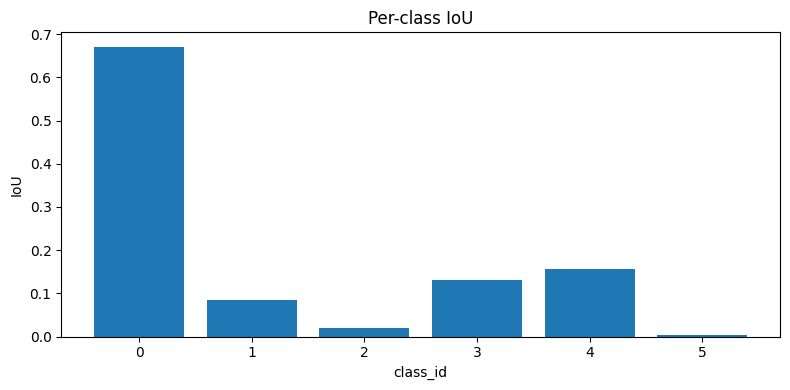

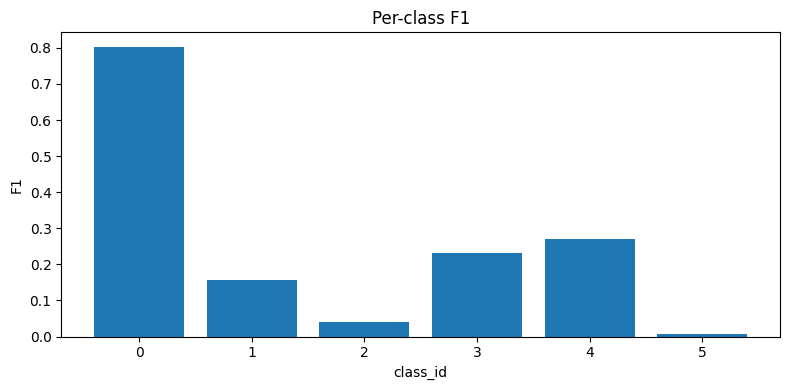

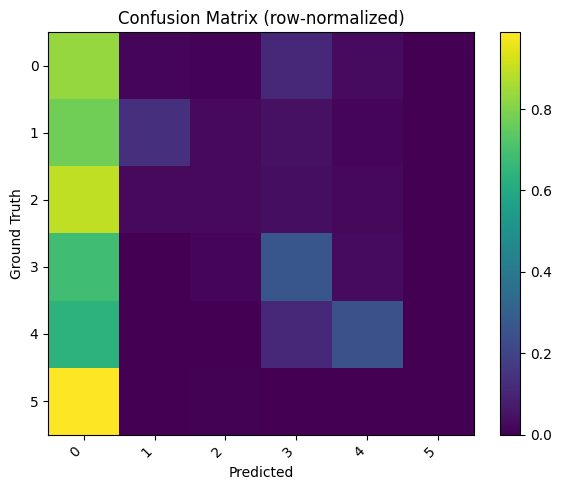

In [9]:
# === QUICK, VERBOSE EVAL (safe for PyTorch 2.6+) ===
import os, json, glob, math, random, pickle
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ------------ settings ------------
CHIPS_DIR   = Path("data_chips")
MANIFEST    = CHIPS_DIR / "manifest.csv"
CKPT_PATH   = Path("models/seg_model.pt")
LABEL_MAP   = next((p for p in [*Path.cwd().glob("*label_map.json"), *Path.cwd().parents[0].glob("*label_map.json")] if p.exists()), None)
N_EVAL_MAX  = 64          # set None to use ALL available chips
PLOTS       = True        # set False for speed

# ------------ model ---------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=64, n_classes=2):
        super().__init__()
        f = 32
        self.down1 = DoubleConv(in_ch, f);   self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(f, f*2);     self.pool2 = nn.MaxPool2d(2)
        self.mid   = DoubleConv(f*2, f*4)
        self.up2   = nn.ConvTranspose2d(f*4, f*2, 2, stride=2)
        self.dec2  = DoubleConv(f*4, f*2)
        self.up1   = nn.ConvTranspose2d(f*2, f, 2, stride=2)
        self.dec1  = DoubleConv(f*2, f)
        self.head  = nn.Conv2d(f, n_classes, 1)
    def forward(self, x):
        d1 = self.down1(x); p1 = self.pool1(d1)
        d2 = self.down2(p1); p2 = self.pool2(d2)
        m  = self.mid(p2)
        u2 = self.up2(m); dd2 = self.dec2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(dd2); dd1 = self.dec1(torch.cat([u1, d1], dim=1))
        return self.head(dd1)

# ------------ loader utils ------------
def load_checkpoint_safe(path: Path, device: torch.device):
    from torch import serialization as ts
    import numpy as _np
    try: ts.add_safe_globals([_np.core.multiarray._reconstruct])
    except Exception: pass
    try:
        return torch.load(path, map_location=device)  # torch>=2.6 defaults to weights_only=True
    except pickle.UnpicklingError:
        return torch.load(path, map_location=device, weights_only=False)

def infer_num_classes_from_state(state_dict: dict):
    w = state_dict.get("head.weight")
    return int(w.shape[0]) if isinstance(w, torch.Tensor) and w.ndim==4 else None

# ------------ datasets ------------
class ChipDataset(torch.utils.data.Dataset):
    def __init__(self, manifest_csv: Path, split: str, mean, std):
        df = pd.read_csv(manifest_csv)
        assert {"split","path"}.issubset(df.columns), "manifest.csv must have 'split' and 'path'"
        df = df[df["split"] == split].reset_index(drop=True)
        if len(df)==0: raise ValueError(f"No chips for split={split}.")
        self.df   = df
        self.mean = mean.astype(np.float32)
        self.std  = np.where(std==0, 1.0, std).astype(np.float32)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        z = np.load(self.df.iloc[i]["path"])
        x = z["x"].astype(np.float32); y = z["y"].astype(np.int64)
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = (x - self.mean) / self.std
        x = np.transpose(x, (2,0,1))
        return torch.from_numpy(x), torch.from_numpy(y)

class FolderChipDataset(torch.utils.data.Dataset):
    def __init__(self, folder: Path, mean, std):
        self.files = sorted(glob.glob(str(folder / "*.npz")))
        if not self.files: raise ValueError(f"No .npz chips under {folder}")
        self.mean = mean.astype(np.float32); self.std = np.where(std==0,1.0,std).astype(np.float32)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        z = np.load(self.files[i])
        x = z["x"].astype(np.float32); y = z["y"].astype(np.int64)
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = (x - self.mean) / self.std
        x = np.transpose(x, (2,0,1))
        return torch.from_numpy(x), torch.from_numpy(y)

# ------------ metrics ------------
def confusion_matrix_torch(pred, targ, K, ignore_index=None):
    p = pred.reshape(-1).to(torch.int64)
    t = targ.reshape(-1).to(torch.int64)
    if ignore_index is not None:
        m = (t != ignore_index); p, t = p[m], t[m]
    valid = (t >= 0) & (t < K)
    inds = K * t[valid] + p[valid]
    return torch.bincount(inds, minlength=K*K).reshape(K, K)

def metrics_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = torch.diag(cm); fp = cm.sum(0) - tp; fn = cm.sum(1) - tp
    iou = torch.where(tp+fp+fn>0, tp/(tp+fp+fn), torch.zeros_like(tp))
    prec = torch.where(tp+fp>0, tp/(tp+fp), torch.zeros_like(tp))
    rec  = torch.where(tp+fn>0, tp/(tp+fn), torch.zeros_like(tp))
    f1   = torch.where(prec+rec>0, 2*prec*rec/(prec+rec), torch.zeros_like(tp))
    overall = (tp.sum()/cm.sum().clamp_min(1)).item()
    df = pd.DataFrame({
        "class_id": np.arange(len(tp)),
        "IoU": iou.cpu().numpy(),
        "F1": f1.cpu().numpy(),
        "Precision": prec.cpu().numpy(),
        "Recall": rec.cpu().numpy(),
        "Support(px)_gt": cm.sum(1).cpu().numpy().astype(np.int64),
        "Pred(px)": cm.sum(0).cpu().numpy().astype(np.int64),
        "TP(px)": tp.cpu().numpy().astype(np.int64),
    })
    return overall, float(iou.mean()), float(f1.mean()), df

def show_cm(cm, title, class_names=None):
    cm_np = cm.cpu().numpy().astype(np.float64)
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_norm = np.nan_to_num(cm_np / cm_np.sum(axis=1, keepdims=True), nan=0.0)
    plt.figure(figsize=(6,5)); plt.imshow(cm_norm, aspect="auto"); plt.colorbar()
    n = cm.shape[0]; ticks = np.arange(n)
    labels = [str(i) for i in ticks] if class_names is None else [class_names.get(i,str(i)) for i in ticks]
    plt.xticks(ticks, labels, rotation=45, ha="right"); plt.yticks(ticks, labels)
    plt.xlabel("Predicted"); plt.ylabel("Ground Truth"); plt.title(title); plt.tight_layout(); plt.show()

# ------------ run ------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert CKPT_PATH.exists(), f"Missing checkpoint: {CKPT_PATH}"
ckpt = load_checkpoint_safe(CKPT_PATH, device)

state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
assert isinstance(state_dict, dict), "Bad checkpoint format."

mean = np.array(ckpt.get("mean", [0.0]*64), dtype=np.float32)
std  = np.array(ckpt.get("std",  [1.0]*64), dtype=np.float32)
std[~np.isfinite(std)] = 1.0; std[std==0] = 1.0

K_meta  = int(ckpt.get("num_classes")) if isinstance(ckpt, dict) and "num_classes" in ckpt else None
K_infer = infer_num_classes_from_state(state_dict)
K = K_meta or K_infer or 2

model = TinyUNet(in_ch=64, n_classes=K).to(device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
if any(k.startswith("head.") for k in missing) or unexpected:
    raise RuntimeError(f"Head mismatch — checkpoint K={K_infer}, meta K={K_meta}, missing={missing}, unexpected={unexpected}")

print(f"✅ Model ready on {device}. NUM_CLASSES={K}")
print("μ/σ[0:5]:", mean[:5], "/", std[:5])

# Decide which split/folder to use
split_order = ["test", "val", "train"]
dataset = None; used_split = None
if MANIFEST.exists():
    df = pd.read_csv(MANIFEST)
    present = {s: int((df["split"]==s).sum()) for s in split_order}
    print("Split counts in manifest:", present)
    for s in split_order:
        if present.get(s,0) > 0:
            dataset = ChipDataset(MANIFEST, s, mean, std); used_split = s; break
if dataset is None:
    try:
        dataset = FolderChipDataset(CHIPS_DIR / "test", mean, std); used_split = "folder:test"
    except Exception as e:
        print("❌ No eval data found. Expected either:")
        print("   - manifest.csv with split in", split_order, "or")
        print(f"   - .npz chips under {CHIPS_DIR/'test'}/")
        raise e

print(f"🔎 Using split: {used_split} | chips found: {len(dataset)}")

# Optional downsample for speed
indices = list(range(len(dataset)))
if N_EVAL_MAX is not None and len(indices) > N_EVAL_MAX:
    random.Random(2025).shuffle(indices)
    indices = indices[:N_EVAL_MAX]
    dataset = torch.utils.data.Subset(dataset, indices)
    print(f"⚡ Fast mode: evaluating only {len(dataset)} chips (set N_EVAL_MAX=None to use all).")

loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)

# Sanity check: run 1 batch immediately
with torch.no_grad():
    X0, Y0 = next(iter(loader))
    logits0 = model(X0.to(device))
    if logits0.shape[-2:] != Y0.shape[-2:]:
        logits0 = F.interpolate(logits0, size=Y0.shape[-2:], mode="bilinear", align_corners=False)
    pred0 = logits0.argmax(1).cpu()
    u, c = np.unique(pred0.numpy(), return_counts=True)
    print("🧪 Sanity batch — pred uniques:", dict(zip(u.tolist(), c.tolist())))

# Full eval (limited by N_EVAL_MAX)
cm_all = torch.zeros((K, K), dtype=torch.int64)
cm_fg  = torch.zeros((K, K), dtype=torch.int64)
seen = 0

with torch.no_grad():
    for step, (X, Y) in enumerate(loader, 1):
        X = X.to(device); Y = Y.to(device)
        logits = model(X)
        if logits.shape[-2:] != Y.shape[-2:]:
            logits = F.interpolate(logits, size=Y.shape[-2:], mode="bilinear", align_corners=False)
        pred = logits.argmax(1)

        cm_all += confusion_matrix_torch(pred, Y, K)
        m = (Y > 0)
        if m.any():
            cm_fg += confusion_matrix_torch(pred[m], Y[m], K)
        seen += X.size(0)
        if step % 25 == 0:
            print(f"   … processed {seen}/{len(dataset)} chips")

overall, miou, mf1, df_all = metrics_from_cm(cm_all)
print("\n=== EVAL (full-tile) ===")
print(f"Overall Acc: {overall:.4f} | mIoU: {miou:.4f} | mF1: {mf1:.4f}")
print(df_all.to_string(index=False))

if cm_fg.sum() > 0:
    overall_fg, miou_fg, mf1_fg, df_fg = metrics_from_cm(cm_fg)
    print("\n=== EVAL (foreground-only, GT>0) ===")
    print(f"mIoU_fg: {miou_fg:.4f} | mF1_fg: {mf1_fg:.4f}")
    print(df_fg.to_string(index=False))

# Optional plots
if PLOTS:
    plt.figure(figsize=(8,4)); plt.bar(df_all["class_id"], df_all["IoU"]); plt.title("Per-class IoU"); plt.xlabel("class_id"); plt.ylabel("IoU"); plt.tight_layout(); plt.show()
    plt.figure(figsize=(8,4)); plt.bar(df_all["class_id"], df_all["F1"]);  plt.title("Per-class F1");  plt.xlabel("class_id"); plt.ylabel("F1");  plt.tight_layout(); plt.show()
    show_cm(cm_all, "Confusion Matrix (row-normalized)")


In [ ]:
# PREDICT → GEO TIFFS (strict load + uniques; pad/crop inside model; negative-stride fix)
import os, json, pickle, zipfile, subprocess
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.windows import Window
import torch
import torch.nn as nn
import torch.nn.functional as F

NAME = "alpha_earth_experiment2.zip"
PRED_DIR = Path("predictions"); PRED_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = Path("models/seg_model.pt")
assert CKPT_PATH.exists(), f"Missing checkpoint: {CKPT_PATH}"

def git_root_or_cwd() -> Path:
    try:
        root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
        return Path(root)
    except Exception:
        return Path.cwd()

candidates = [Path("datasets")/NAME, Path("../datasets")/NAME, Path("../../datasets")/NAME, Path(NAME)]
ZIP_PATH = next((c.resolve() for c in candidates if c.exists()), None)
if ZIP_PATH is None:
    root = git_root_or_cwd()
    ZIP_PATH = next((p.resolve() for p in root.rglob(NAME)), None)
assert ZIP_PATH and ZIP_PATH.exists(), f"Couldn't find {NAME}"

with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    MEMBERS = sorted([m for m in zf.namelist() if m.lower().endswith(".tif")])
print(f"ZIP: {ZIP_PATH} | {len(MEMBERS)} GeoTIFF(s)")

# ----- model (same as train) -----
def gn(channels, groups=8):
    g = min(groups, channels)
    while channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, channels)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            gn(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            gn(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=64, n_classes=9):
        super().__init__()
        f = 32
        self.down1 = DoubleConv(in_ch, f)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(f, f*2)
        self.pool2 = nn.MaxPool2d(2)
        self.mid   = DoubleConv(f*2, f*4)
        self.up2   = nn.ConvTranspose2d(f*4, f*2, 2, stride=2)
        self.dec2  = DoubleConv(f*4, f*2)
        self.up1   = nn.ConvTranspose2d(f*2, f, 2, stride=2)
        self.dec1  = DoubleConv(f*2, f)
        self.head  = nn.Conv2d(f, n_classes, 1)

    @staticmethod
    def _pad_to_mult4(x: torch.Tensor):
        _, _, H, W = x.shape
        pad_h = (-H) % 4; pad_w = (-W) % 4
        return (F.pad(x, (0, pad_w, 0, pad_h), mode="reflect") if (pad_h or pad_w) else x), H, W

    def forward(self, x):
        x, H0, W0 = self._pad_to_mult4(x)
        d1 = self.down1(x); p1 = self.pool1(d1)
        d2 = self.down2(p1); p2 = self.pool2(d2)
        m  = self.mid(p2)
        u2 = self.up2(m); dd2 = self.dec2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(dd2); dd1 = self.dec1(torch.cat([u1, d1], dim=1))
        out = self.head(dd1)
        return out[..., :H0, :W0]

# ----- load ckpt strictly -----
def load_ckpt_safe(path: Path):
    try:
        from torch import serialization as ts
        import numpy as _np
        try:
            ts.add_safe_globals([_np.core.multiarray._reconstruct])
        except Exception:
            pass
        return torch.load(path, map_location="cpu")
    except pickle.UnpicklingError:
        return torch.load(path, map_location="cpu", weights_only=False)

ckpt = load_ckpt_safe(CKPT_PATH)
NUM_CLASSES = int(ckpt.get("num_classes", 2))
mean = np.array(ckpt.get("mean", [0.0]*64), dtype=np.float32)
std  = np.array(ckpt.get("std",  [1.0]*64), dtype=np.float32)
std[~np.isfinite(std)] = 1.0; std[std==0] = 1.0

model = TinyUNet(in_ch=64, n_classes=NUM_CLASSES)
state_dict = ckpt["model"] if "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
print(f"Model ready on {device}. NUM_CLASSES={NUM_CLASSES}")
print("mean/std[0:5]:", mean[:5], "/", std[:5])

# ----- sliding window -----
def win_slices(h, w, tile=256, overlap=32):
    stride = max(1, tile - overlap)
    rows = list(range(0, max(1, h - tile + 1), stride)) or [0]
    cols = list(range(0, max(1, w - tile + 1), stride)) or [0]
    if rows[-1] + tile < h: rows.append(h - tile)
    if cols[-1] + tile < w: cols.append(w - tile)
    for r0 in rows:
        for c0 in cols:
            r1 = min(r0 + tile, h); c1 = min(c0 + tile, w)
            yield r0, c0, r1 - r0, c1 - c0

@torch.inference_mode()
def predict_member(zip_path: Path, member: str, out_dir: Path,
                   tile=256, overlap=32, bands=64, write_probs=False):
    vsi = f"zip://{zip_path}!{member}"
    with rio.open(vsi) as src:
        H, W = src.height, src.width
        assert src.count >= bands, f"{member} has {src.count} bands (<{bands})."
        y_pred = np.zeros((H, W), dtype=np.uint8)

        if write_probs:
            probs_acc = np.zeros((int(NUM_CLASSES), H, W), dtype=np.float32)
            counts    = np.zeros((H, W), dtype=np.uint8)

        for r0, c0, h, w in win_slices(H, W, tile=tile, overlap=overlap):
            win = Window(c0, r0, w, h)
            x = src.read(indexes=list(range(1, bands+1)), window=win).astype(np.float32)  # (C,h,w)
            x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            x = (x - mean[:, None, None]) / std[:, None, None]
            x = np.ascontiguousarray(x, dtype=np.float32)  # 🔧 fix negative/odd strides

            X = torch.from_numpy(x[None, ...]).to(device)   # (1,C,h,w)
            logits = model(X)                                # (1,K,h,w) after crop
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
            y_pred[r0:r0+h, c0:c0+w] = pred

            if write_probs:
                p = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
                probs_acc[:, r0:r0+h, c0:c0+w] += p
                counts[r0:r0+h, c0:c0+w] += 1

        # debug: unique class histogram
        u, c = np.unique(y_pred, return_counts=True)
        print(f"{Path(member).name} | pred uniques:", dict(zip(u.tolist(), c.tolist())))

        transform = src.transform; crs = src.crs

    out_dir.mkdir(parents=True, exist_ok=True)
    stem = Path(member).stem
    out_tif = out_dir / f"{stem}_pred.tif"
    profile = dict(driver="GTiff", height=H, width=W, count=1, dtype="uint8",
                   crs=crs, transform=transform, compress="LZW",
                   tiled=True, blockxsize=256, blockysize=256)
    with rio.open(out_tif, "w", **profile) as dst:
        dst.write(y_pred, 1)
        try:
            cmap = {0: (0,0,0,255)}
            rng = np.random.default_rng(42)
            for cid in range(1, int(NUM_CLASSES)):
                r,g,b = rng.integers(40,255, size=3).tolist()
                cmap[cid] = (int(r), int(g), int(b), 255)
            dst.write_colormap(1, cmap)
        except Exception:
            pass

    if write_probs:
        counts_safe = np.maximum(counts, 1)[None, :, :]
        probs_avg = probs_acc / counts_safe
        prob_tif = out_dir / f"{stem}_probs.tif"
        prob_prof = profile.copy(); prob_prof.update(count=int(NUM_CLASSES), dtype="float32")
        with rio.open(prob_tif, "w", **prob_prof) as dst:
            dst.write(probs_avg.astype(np.float32))

    return out_tif

# ----- run -----
TILE      = 256
OVERLAP   = 32
WRITE_PROBS = False
LIMIT = None  # set small int to test

print(f"→ Predicting {len(MEMBERS if LIMIT is None else MEMBERS[:LIMIT])} file(s)...")
written = []
for m in (MEMBERS if LIMIT is None else MEMBERS[:LIMIT]):
    try:
        out = predict_member(ZIP_PATH, m, PRED_DIR, tile=TILE, overlap=OVERLAP, bands=64, write_probs=WRITE_PROBS)
        print("✔", out)
        written.append(out)
    except Exception as e:
        print("✖", m, "->", e)

print(f"Done. Wrote {len(written)} prediction TIFF(s) to {PRED_DIR}/")


ZIP: /app/datasets/alpha_earth_experiment2.zip | 500 GeoTIFF(s)
Model ready on cpu. NUM_CLASSES=6
mean/std[0:5]: [ 0.02092375 -0.01565236 -0.08934581  0.04202067  0.07773721] / [0.03910081 0.04257318 0.05128002 0.05624174 0.03230617]
→ Predicting 500 file(s)...
alphaearth_embeddings_2024_sq_001_cls3.tif | pred uniques: {0: 302391, 3: 96714}
✔ predictions/alphaearth_embeddings_2024_sq_001_cls3_pred.tif
alphaearth_embeddings_2024_sq_002_cls3.tif | pred uniques: {0: 289007, 3: 66321}
✔ predictions/alphaearth_embeddings_2024_sq_002_cls3_pred.tif
alphaearth_embeddings_2024_sq_003_cls3.tif | pred uniques: {0: 227847, 3: 102639}
✔ predictions/alphaearth_embeddings_2024_sq_003_cls3_pred.tif
alphaearth_embeddings_2024_sq_004_cls3.tif | pred uniques: {0: 215410, 3: 111596}
✔ predictions/alphaearth_embeddings_2024_sq_004_cls3_pred.tif
alphaearth_embeddings_2024_sq_005_cls3.tif | pred uniques: {0: 265971, 3: 53331}
✔ predictions/alphaearth_embeddings_2024_sq_005_cls3_pred.tif
alphaearth_embeddings

KeyboardInterrupt: 


File: predictions/alphaearth_embeddings_2024_sq_186_cls4_pred.tif
Shape (H, W): (134, 174) | Bands: 1 | Dtype: uint8
Unique labels: {0: 13386, 4: 9930}


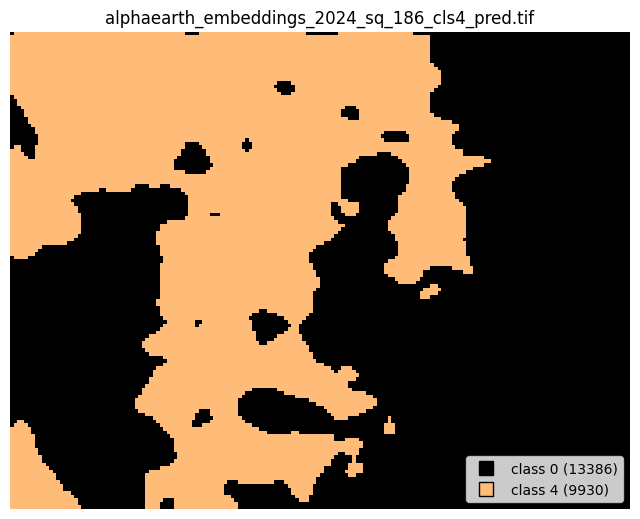


File: predictions/alphaearth_embeddings_2024_sq_188_cls2_pred.tif
Shape (H, W): (135, 184) | Bands: 1 | Dtype: uint8
Unique labels: {0: 20191, 2: 121, 3: 159, 5: 4369}


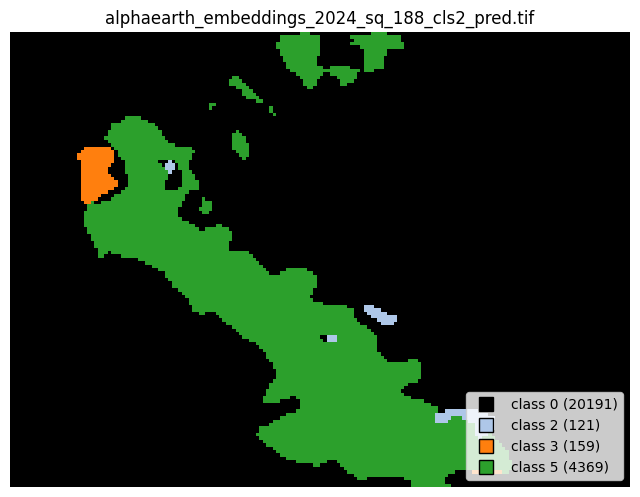


File: predictions/alphaearth_embeddings_2024_sq_197_cls2_pred.tif
Shape (H, W): (132, 180) | Bands: 1 | Dtype: uint8
Unique labels: {0: 23297, 1: 450, 2: 13}


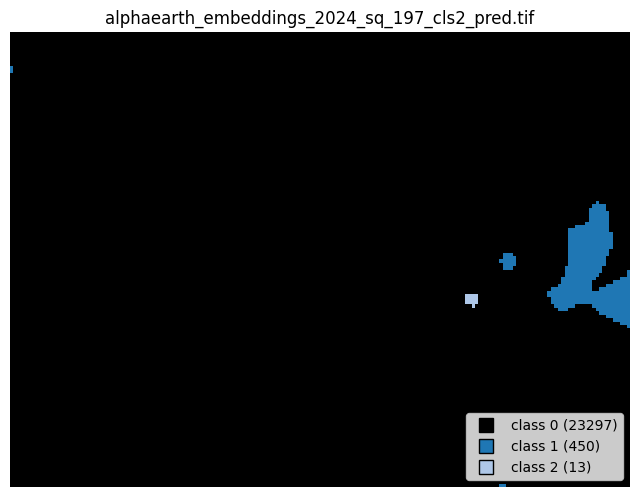

In [15]:
# Visualize one or more prediction GeoTIFF masks from BASE_DIR="predictions"
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import json
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

# ---- edit this list with basenames under predictions/ ----
FILENAMES = [
    "alphaearth_embeddings_2024_sq_186_cls4_pred.tif",
    "alphaearth_embeddings_2024_sq_188_cls2_pred.tif",
    "alphaearth_embeddings_2024_sq_197_cls2_pred.tif"
]
# ----------------------------------------------------------

BASE_DIR = Path("predictions")
SHOW_LEGEND = True
USE_TIFF_COLORMAP = False  # set True to try the embedded colormap, but custom palette is safer

# optional: try to find a *label_map.json (either {name:id} or {id:name})
def find_label_map():
    for p in [Path.cwd(), *Path.cwd().parents]:
        hits = list(p.glob("*label_map.json"))
        if hits:
            try:
                with open(hits[0], "r") as f:
                    mp = json.load(f)
                # normalize to {int_id: name}
                if all(isinstance(k, str) and k.isdigit() for k in mp.keys()):
                    return {int(k): str(v) for k, v in mp.items()}
                else:
                    # probably {name: id}
                    inv = {}
                    for name, idx in mp.items():
                        try:
                            inv[int(idx)] = str(name)
                        except Exception:
                            pass
                    return inv
            except Exception:
                pass
    return {}

ID2NAME = find_label_map()

def make_discrete_cmap(max_id: int):
    """Background 0 = black; classes 1..max_id use tab20 cycling."""
    import matplotlib
    N = int(max(1, max_id)) + 1
    colors = [(0, 0, 0, 1.0)]  # class 0
    base = matplotlib.cm.get_cmap("tab20")
    for i in range(1, N):
        c = base((i - 1) % base.N)
        colors.append((c[0], c[1], c[2], 1.0))
    cmap = ListedColormap(colors, N=N)
    norm = BoundaryNorm(np.arange(-0.5, N + 0.5, 1), N)
    return cmap, norm

def build_cmap_from_tiff(ds, data_max):
    """Use TIFF colormap if it fully covers 0..data_max; else fall back to discrete cmap."""
    try:
        cm = ds.colormap(1)  # dict: {id: (r,g,b,a)}
        if not cm:
            raise ValueError("no colormap in TIFF")
        # ensure we cover all ids up to data_max
        need_N = int(data_max) + 1
        max_key = max(cm.keys())
        N = max(need_N, max_key + 1)
        colors = []
        for k in range(N):
            if k in cm:
                r, g, b, a = cm[k]
                colors.append((r/255.0, g/255.0, b/255.0, a/255.0))
            else:
                # fall back to a visible color (not transparent) so classes show up
                colors.append((0, 0, 0, 1.0) if k == 0 else (1.0, 0.0, 1.0, 1.0))
        cmap = ListedColormap(colors, N=N)
        norm = BoundaryNorm(np.arange(-0.5, N + 0.5, 1), N)
        return cmap, norm
    except Exception:
        # fallback
        return make_discrete_cmap(int(data_max))

if not FILENAMES:
    print("FILENAMES is empty — add one or more .tif names from the predictions folder.")
else:
    for name in FILENAMES:
        tif_path = BASE_DIR / name
        if not tif_path.exists():
            print(f"❌ Not found: {tif_path}")
            continue

        try:
            with rio.open(tif_path) as ds:
                mask = ds.read(1)  # (H,W), uint8 class IDs
                uniques, counts = np.unique(mask, return_counts=True)
                max_id = int(uniques.max()) if uniques.size else 0

                print(f"\nFile: {tif_path}")
                print("Shape (H, W):", mask.shape, "| Bands:", ds.count, "| Dtype:", ds.dtypes[0])
                print("Unique labels:", dict(zip(uniques.tolist(), counts.tolist())))

                # Choose colormap
                if USE_TIFF_COLORMAP:
                    cmap, norm = build_cmap_from_tiff(ds, max_id)
                else:
                    cmap, norm = make_discrete_cmap(max_id)

                # Plot
                plt.figure(figsize=(8, 8))
                im = plt.imshow(mask, cmap=cmap, norm=norm, interpolation="nearest")
                plt.title(tif_path.name)
                plt.axis("off")

                # Legend for present classes only
                if SHOW_LEGEND and uniques.size:
                    handles, labels = [], []
                    for k, cnt in zip(uniques.tolist(), counts.tolist()):
                        color = cmap(k)
                        handles.append(Line2D([0], [0], marker='s', linestyle='None',
                                              markersize=10, markerfacecolor=color, markeredgecolor='k'))
                        name = ID2NAME.get(k, f"class {k}")
                        labels.append(f"{name} ({cnt})")
                    plt.legend(handles, labels, loc="lower right", framealpha=0.8)
                plt.show()

        except Exception as e:
            print(f"⚠️ Failed to visualize {tif_path}: {e}")
